### Sample program for VAE  

#### Import libraries  

In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import  os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' 

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
np.random.seed(11)
tf.random.set_seed(13)

2022-01-20 22:44:14.335490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 22:44:14.335527: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Parameters  

In [2]:
n_digits = 5
n_train = 4800
n_test = 800

#### Function for Z-sampling between encoder and decoder  

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim),
                              mean=0., stddev=1. )
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#### Function for visualization of data in latent space  

In [4]:
def plot_results(models, data, batch_size=128):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
    """

    encoder, decoder = models
    test_data, test_label = data

    # display a 2D manifold of digits
    z_mean1, _, _ = encoder.predict(test_data,
                                   batch_size=batch_size)
    plt.figure(figsize=(9, 7))
    plt.scatter(z_mean1[:, 0], z_mean1[:, 1], c=test_label)
    plt.colorbar()
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.show()

    # display a 2D manifold of digits
    n = 15
    figure = np.zeros((img_h * n, img_w * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_h, img_w)
            figure[i * img_h: (i + 1) * img_h,
                   j * img_w: (j + 1) * img_w] = digit

    plt.figure(figsize=(7, 7))
    start_range_x = img_w // 2
    end_range_x = (n - 1) * img_w + start_range_x + 1
    pixel_range_x = np.arange(start_range_x, end_range_x, img_w)
    start_range_y = img_h // 2
    end_range_y = (n - 1) * img_h + start_range_y + 1
    pixel_range_y = np.arange(start_range_y, end_range_y, img_h)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

#### Load MNIST  

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


#### Select only 0..(n_digits-1)  

In [6]:
x_train = x_train[ y_train < n_digits ]
y_train = y_train[ y_train < n_digits ]
x_test = x_test[ y_test < n_digits ]
y_test = y_test[ y_test < n_digits ]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(30596, 28, 28) (30596,)
(5139, 28, 28) (5139,)


#### Check the number of each label  

In [7]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    6742
3    6131
2    5958
0    5923
4    5842
dtype: int64
1    1135
2    1032
3    1010
4     982
0     980
dtype: int64


#### Reduce the number of data (for shorter calculation time)  

In [8]:
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(4800, 28, 28) (800, 28, 28)
(4800,) (800,)


#### Check the number of each label  

In [9]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    1063
3     960
0     929
4     927
2     921
dtype: int64
1    179
2    172
4    167
3    155
0    127
dtype: int64


#### Obtain size of image  

In [10]:
img_h = x_train.shape[1]
img_w = x_train.shape[2]
original_dim = img_h * img_w
print(img_h, img_w, original_dim)

28 28 784


#### Re-scale data (0..1) and flatten  

In [11]:
x_train = x_train.astype('float32') / 255
x_train = x_train.reshape(-1, original_dim)
print(x_train.shape)
x_test = x_test.astype('float32') / 255
x_test = x_test.reshape(-1, original_dim)
print(x_test.shape)

(4800, 784)
(800, 784)


#### See images  

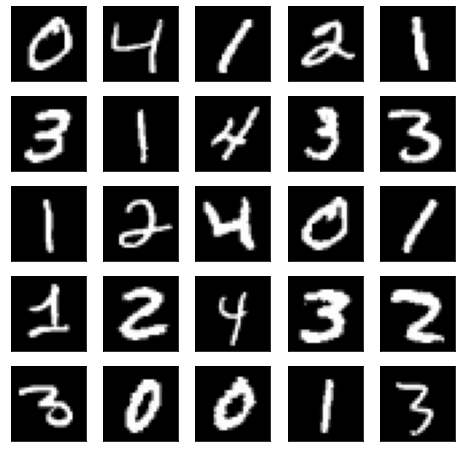

In [12]:
fig = plt.figure(figsize=(8, 8))  # don't move to other cell
tile_h = 5
tile_w = 5
for i in range(tile_h*tile_w):
    fig.add_subplot(tile_h, tile_w, i+1, xticks=[], yticks=[])
    plt.imshow(x_train[i].reshape((img_h, img_w)), cmap='gray')
    
plt.show()

#### Start VAE calculation  

In [13]:
K.clear_session()

#### Parameters for dense and latent space  

In [14]:
input_shape = (original_dim, )
intermediate_dim = 512
latent_dim = 2

#### Build VAE model = encoder + decoder

In [15]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          262656      dense_1[0][0]                    
____________________________________________________________________________________________

In [16]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 929,040
Trainable params: 929,040
Non-trainable params: 0
_________________________________________________________________


#### Define the whole model  

In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])  # encoder(input)[2]: z
vae = Model(inputs, outputs, name='vae')

#### Function to calculate loss  

In [18]:
def vae_loss(y_true, y_pred):
    reconstruction_loss = binary_crossentropy(y_true,
                                              y_pred)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1) / 2
    ret = K.mean(reconstruction_loss - kl_loss)
    return ret

#### Set optimization parameters  

In [19]:
vae.compile(optimizer='adam', loss=vae_loss,
            experimental_run_tf_function=False)
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 929284    
_________________________________________________________________
decoder (Functional)         (None, 784)               929040    
Total params: 1,858,324
Trainable params: 1,858,324
Non-trainable params: 0
_________________________________________________________________


#### Exec learning (training)  

In [20]:
batch_size = 32
epochs = 40
val_split = 0.1
input_data = x_train
teacher_data = x_train
input_test_data = x_test
true_test_data = x_test
true_test_label = y_test

In [21]:
%%time

fit_log = vae.fit(input_data, teacher_data,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=val_split)

Train on 4320 samples, validate on 480 samples
Epoch 1/40


2022-01-20 22:44:20.515428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 22:44:20.515458: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 22:44:20.515474: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anhvu): /proc/driver/nvidia/version does not exist
2022-01-20 22:44:20.515844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4320/4320 [==============================] - 2s 445us/sample - loss: 208.4846 - val_loss: 175.6309
Epoch 2/40
4320/4320 [==============================] - 1s 336us/sample - loss: 166.9644 - val_loss: 167.7080
Epoch 3/40
4320/4320 [==============================] - 1s 335us/sample - loss: 159.5357 - val_loss: 160.6254
Epoch 4/40
4320/4320 [==============================] - 1s 334us/sample - loss: 155.6047 - val_loss: 158.4181
Epoch 5/40
4320/4320 [==============================] - 2s 379us/sample - loss: 151.6594 - val_loss: 155.9136
Epoch 6/40
4320/4320 [==============================] - 1s 346us/sample - loss: 148.4219 - val_loss: 154.2678
Epoch 7/40
4320/4320 [==============================] - 2s 361us/sample - loss: 146.1873 - val_loss: 152.7379
Epoch 8/40
4320/4320 [==============================] - 1s 331us/sample - loss: 144.2474 - val_loss: 151.3326
Epoch 9/40
4320/4320 [==============================] - 1s 335us/sample - loss: 142.3151 - val_loss: 149.5331
Epoch 10/40
4320/4320

#### Plot of loss/val_loss vs epochs  

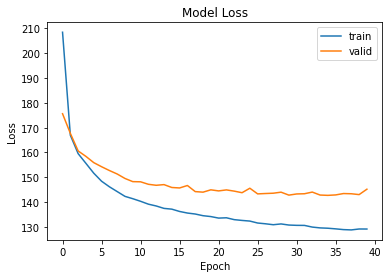

In [22]:
plt.plot(fit_log.history['loss'], label='train')
plt.plot(fit_log.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Analysis of the results   

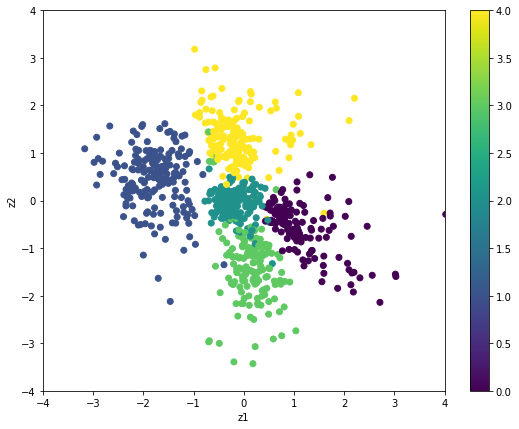

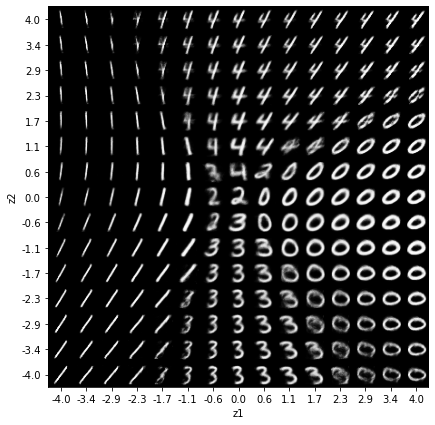

In [23]:
models = (encoder, decoder)
data = (input_test_data, y_test)

plot_results(models, data,
             batch_size=batch_size)

##### Obtain output for test_data   

In [24]:
pred = vae.predict(input_test_data)

##### Show sample images  

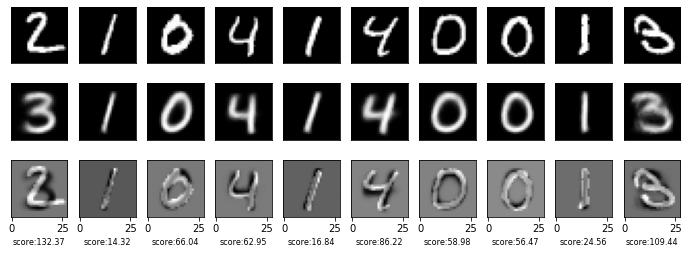

In [25]:
n = 10
plt.figure(figsize=(12, 4))
for i in range(n):
    # Show input test image
    ax = plt.subplot(3, n, i+1)
    plt.imshow(input_test_data[i].reshape(img_h, img_w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # Show output test image
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(pred[i].reshape(img_h, img_w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Obtain diff between images
    diff_img = true_test_data[i] - pred[i]
    
    # Obtain total value of diff between images  
    diff_score1 = np.sum(np.abs(true_test_data[i]-pred[i]))
        
    # Show results  
    ax = plt.subplot(3, n, i+1+n*2)
    plt.imshow(diff_img.reshape(img_h, img_w))
    plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False) 
    ax.set_xlabel('score:{:.2f}'.format(diff_score1), fontsize=8)    
    
plt.show()

##### Show distribution of scores  

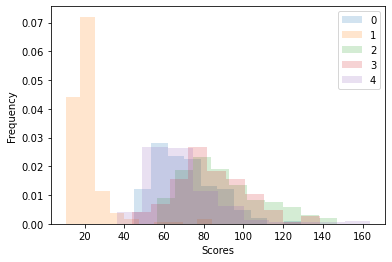

In [26]:
diff_scores = []
diff_labels = []
for i in range(len(input_test_data)):   
    # Obtain total value of diff between images  
    diff_score = np.sum(np.abs(true_test_data[i]-pred[i]))
    diff_scores.append(diff_score)
    diff_labels.append(true_test_label[i])

diff_scores = np.array(diff_scores)
diff_labels = np.array(diff_labels)

for i in range(n_digits):
    plt.hist(diff_scores[ diff_labels==i ], label=str(i), density=True, alpha=0.2)
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()